# Codecademy NLP Portfolio Project: Text Message Analysis

* [Loading and Initial Data Cleaning](#1)
* [Analysis Plan](#2)
* [Text Preprocessing](#3)
* [Tf-idf](#4)
* [LDA](#5)
* [Sentiment Analysis](#6)
* [Conclusion](#7)

In [1]:
#Importing packages

import pandas as pd
import numpy as np

#preprocessing
import re
import contractions
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk import RegexpParser, Tree
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from collections import Counter
from nltk.stem import WordNetLemmatizer

#modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

## Loading and Initial Data Cleaning<a class="anchor" id="1"></a>

In [2]:
#Import dataset
df = pd.read_csv('clean_nus_sms.csv')

#Explore dataset
df.head()

,Unnamed: 0,id,Message,length,country,Date
0,0,10120,Bugis oso near wat...,21,SG,2003/4
1,1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4
3,3,10123,Den only weekdays got special price... Haiz......,140,SG,2003/4
4,4,10124,Meet after lunch la...,22,SG,2003/4


In [3]:
#Explore dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48598 entries, 0 to 48597
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  48598 non-null  int64 
 1   id          48598 non-null  int64 
 2   Message     48595 non-null  object
 3   length      48598 non-null  object
 4   country     48598 non-null  object
 5   Date        48598 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.2+ MB


#### Conduct some initial data cleaning and formatting

In [4]:
#Remove previous index column
df = df.drop(columns = 'Unnamed: 0')

#Check work
df.head()

,id,Message,length,country,Date
0,10120,Bugis oso near wat...,21,SG,2003/4
1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4
2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4
3,10123,Den only weekdays got special price... Haiz......,140,SG,2003/4
4,10124,Meet after lunch la...,22,SG,2003/4


In [5]:
#Make all column names lowercase for consistency
df = df.rename(columns = {'Message':'message', 'Date':'date'})

#check work
df.head()

,id,message,length,country,date
0,10120,Bugis oso near wat...,21,SG,2003/4
1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4
2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4
3,10123,Den only weekdays got special price... Haiz......,140,SG,2003/4
4,10124,Meet after lunch la...,22,SG,2003/4


In [6]:
#Make length numeric
df['length'] = pd.to_numeric(df['length'], errors='coerce')

#Check work
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48598 entries, 0 to 48597
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       48598 non-null  int64  
 1   message  48595 non-null  object 
 2   length   48594 non-null  float64
 3   country  48598 non-null  object 
 4   date     48598 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 1.9+ MB
None


,id,length
count,48598.000000,48594.000000
mean,21106.315342,54.850434
std,12189.313543,53.203030
min,1.000000,1.000000
25%,12100.000000,21.000000
50%,18553.000000,39.000000
75%,29964.500000,70.000000
max,45718.000000,910.000000


In [7]:
#check that length is not missing for any
df['length_error'] = np.where(df['length'].isnull(),1,0)

#error if any = 1
df['length_error'].value_counts()

0    48594
1        4
Name: length_error, dtype: int64

In [8]:
#View rows where there is a length error
df[df['length_error']==1]

,id,message,length,country,date,length_error
9468,19896,Err:511,NaN,SG,2003/4,1
18485,10441,Err:509,NaN,United States,2011/3,1
31264,24234,Err:508,NaN,Singapore,2011/4,1
32286,25413,Err:510,NaN,Singapore,2011/4,1


In [9]:
#Let's drop these rows as they appear to be messages with missing data
df = df[df['length_error']==0]

#and drop 'lenth_error'
df = df.drop(columns = 'length_error')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48594 entries, 0 to 48597
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       48594 non-null  int64  
 1   message  48591 non-null  object 
 2   length   48594 non-null  float64
 3   country  48594 non-null  object 
 4   date     48594 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 2.2+ MB


In [10]:
#Explore country variable
df['country'].value_counts()

Singapore              22011
SG                      9805
India                   6901
United States           3748
USA                     1932
Sri Lanka               1017
Malaysia                 766
Pakistan                 751
unknown                  602
Canada                   198
Bangladesh               126
China                    107
india                    105
INDIA                     79
Philippines               67
Indonesia                 48
Nepal                     39
srilanka                  30
United Kingdom            30
Hungary                   28
Serbia                    22
Kenya                     20
Ghana                     18
Italia                    10
Turkey                    10
Trinidad and Tobago       10
Lebanon                   10
Slovenia                  10
Nigeria                   10
New Zealand               10
Macedonia                 10
UK                        10
Morocco                    9
Romania                    9
Australia     

In [11]:
#Let's clean these up so there is only one value per country
df['country'] = df['country'].str.lower()

#Check work
df['country'].value_counts().sort_index()

australia                  9
bangladesh               126
barbados                   8
canada                   198
china                    107
france                     5
ghana                     18
hungary                   28
india                   7085
indonesia                 48
italia                    10
jamaica                    8
kenya                     20
lebanon                   10
macedonia                 10
malaysia                 766
morocco                    9
my                         1
nepal                     39
new zealand               10
nigeria                   10
pakistan                 751
philippines               67
romania                    9
serbia                    22
sg                      9805
singapore              22011
slovenia                  10
spain                      5
sri lanka               1017
srilanka                  30
trinidad and tobago       10
turkey                    10
uk                        10
united kingdom

In [12]:
#Convert country acronyms to name for consistency
df['country'] = df['country'].replace({"my":"malaysia", "sg":"singapore", 
                                       "srilanka":"sri lanka", "uk":"united kingdom", 
                                       "usa":"united states"})

#Check work
df['country'].value_counts().sort_index()

australia                  9
bangladesh               126
barbados                   8
canada                   198
china                    107
france                     5
ghana                     18
hungary                   28
india                   7085
indonesia                 48
italia                    10
jamaica                    8
kenya                     20
lebanon                   10
macedonia                 10
malaysia                 767
morocco                    9
nepal                     39
new zealand               10
nigeria                   10
pakistan                 751
philippines               67
romania                    9
serbia                    22
singapore              31816
slovenia                  10
spain                      5
sri lanka               1047
trinidad and tobago       10
turkey                    10
united kingdom            40
united states           5680
unknown                  602
Name: country, dtype: int64

In [13]:
#Let's just keep countries where English is the primary language spoken
eng_countries = ["australia","barbados","canada","ghana","jamaica","new zealand","trinidad and tobago","united kingdom","united states"]

df = df[df['country'].isin(eng_countries)].reset_index().drop(columns="index")

print(df.info())
print(df.head())
df['country'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5981 entries, 0 to 5980
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       5981 non-null   int64  
 1   message  5980 non-null   object 
 2   length   5981 non-null   float64
 3   country  5981 non-null   object 
 4   date     5981 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 233.8+ KB
None
     id                                    message  length        country  \
0  1678                          Back atcha, doll!    17.0  united states   
1  1679  Your message was blank! Same to you, LOL!    41.0  united states   
2  1680           Yoo silly! Luv ya much, lil sis.    32.0  united states   
3  1681                  You betta be takin' pics!    25.0  united states   
4  1682                                  Jus bout.     9.0  united states   

     date  
0  2011/1  
1  2011/1  
2  2011/1  
3  2011/1  
4  2011/1  


united states          5680
canada                  198
united kingdom           40
ghana                    18
new zealand              10
trinidad and tobago      10
australia                 9
jamaica                   8
barbados                  8
Name: country, dtype: int64

## Analysis Plan<a class="anchor" id="2"></a>

What insights would you like to learn and share from this data?
* What are the key topics across these SMS messages?
* What is the general sentiment of these messages?

NLP models to be used in analysis:
* Bag-of-Words (BoW)
* Term Frequency-Inverse Document Frequency (tf-idf)

## Text Preprocessing<a class="anchor" id="3"></a>

#### Text formatting
* lowercase
* removing white space
* converting contractions
* removing special characters and punctuation

In [14]:
#lowercase
df['message_clean'] = df['message'].str.lower()

#check work
df.head()

,id,message,length,country,date,message_clean
0,1678,"Back atcha, doll!",17.0,united states,2011/1,"back atcha, doll!"
1,1679,"Your message was blank! Same to you, LOL!",41.0,united states,2011/1,"your message was blank! same to you, lol!"
2,1680,"Yoo silly! Luv ya much, lil sis.",32.0,united states,2011/1,"yoo silly! luv ya much, lil sis."
3,1681,You betta be takin' pics!,25.0,united states,2011/1,you betta be takin' pics!
4,1682,Jus bout.,9.0,united states,2011/1,jus bout.


In [15]:
#removing white space

#remove extra white space (any two+ white spaces)
df['message_clean'] = [re.sub(r'\s{2,}', ' ', x) for x in df['message_clean'].astype(str)]

#then remove leading white space
df['message_clean'] = [re.sub(r'^\s','', x) for x in df['message_clean'].astype(str)]

#finally remove trailing white space
df['message_clean'] = [re.sub(r'\s$','', x) for x in df['message_clean'].astype(str)]

#check work
df.head()

,id,message,length,country,date,message_clean
0,1678,"Back atcha, doll!",17.0,united states,2011/1,"back atcha, doll!"
1,1679,"Your message was blank! Same to you, LOL!",41.0,united states,2011/1,"your message was blank! same to you, lol!"
2,1680,"Yoo silly! Luv ya much, lil sis.",32.0,united states,2011/1,"yoo silly! luv ya much, lil sis."
3,1681,You betta be takin' pics!,25.0,united states,2011/1,you betta be takin' pics!
4,1682,Jus bout.,9.0,united states,2011/1,jus bout.


In [16]:
#convert contactions
df['message_clean'] = [contractions.fix(x) for x in df['message_clean']]

#check work
df.head()

,id,message,length,country,date,message_clean
0,1678,"Back atcha, doll!",17.0,united states,2011/1,"back atcha, doll!"
1,1679,"Your message was blank! Same to you, LOL!",41.0,united states,2011/1,"your message was blank! same to you, lol!"
2,1680,"Yoo silly! Luv ya much, lil sis.",32.0,united states,2011/1,"yoo silly! love ya much, lil sis."
3,1681,You betta be takin' pics!,25.0,united states,2011/1,you betta be takin' pics!
4,1682,Jus bout.,9.0,united states,2011/1,jus bout.


In [17]:
#remove special characters
df['message_clean'] = [re.sub('[^a-zA-Z 0-9]', '', x) for x in df['message_clean'].astype(str)]

#check work
df.head()

,id,message,length,country,date,message_clean
0,1678,"Back atcha, doll!",17.0,united states,2011/1,back atcha doll
1,1679,"Your message was blank! Same to you, LOL!",41.0,united states,2011/1,your message was blank same to you lol
2,1680,"Yoo silly! Luv ya much, lil sis.",32.0,united states,2011/1,yoo silly love ya much lil sis
3,1681,You betta be takin' pics!,25.0,united states,2011/1,you betta be takin pics
4,1682,Jus bout.,9.0,united states,2011/1,jus bout


#### Tokenization

In [18]:
df['message_tokenized'] = [word_tokenize(x) for x in df['message_clean']]

#check work
df.head()

,id,message,length,country,date,message_clean,message_tokenized
0,1678,"Back atcha, doll!",17.0,united states,2011/1,back atcha doll,"[back, atcha, doll]"
1,1679,"Your message was blank! Same to you, LOL!",41.0,united states,2011/1,your message was blank same to you lol,"[your, message, was, blank, same, to, you, lol]"
2,1680,"Yoo silly! Luv ya much, lil sis.",32.0,united states,2011/1,yoo silly love ya much lil sis,"[yoo, silly, love, ya, much, lil, sis]"
3,1681,You betta be takin' pics!,25.0,united states,2011/1,you betta be takin pics,"[you, betta, be, takin, pics]"
4,1682,Jus bout.,9.0,united states,2011/1,jus bout,"[jus, bout]"


#### Part-of-Speech Tagging
* !Takes a while to run

In [21]:
df['message_pos'] = [pos_tag(x) for x in df['message_tokenized']]

#check work
df.head()

,id,message,length,country,date,message_clean,message_tokenized,message_pos
0,1678,"Back atcha, doll!",17.0,united states,2011/1,back atcha doll,"[back, atcha, doll]","[(back, RB), (atcha, NN), (doll, NN)]"
1,1679,"Your message was blank! Same to you, LOL!",41.0,united states,2011/1,your message was blank same to you lol,"[your, message, was, blank, same, to, you, lol]","[(your, PRP$), (message, NN), (was, VBD), (bla..."
2,1680,"Yoo silly! Luv ya much, lil sis.",32.0,united states,2011/1,yoo silly love ya much lil sis,"[yoo, silly, love, ya, much, lil, sis]","[(yoo, RB), (silly, RB), (love, VB), (ya, RB),..."
3,1681,You betta be takin' pics!,25.0,united states,2011/1,you betta be takin pics,"[you, betta, be, takin, pics]","[(you, PRP), (betta, VBP), (be, VB), (takin, J..."
4,1682,Jus bout.,9.0,united states,2011/1,jus bout,"[jus, bout]","[(jus, NN), (bout, NN)]"


#### Chunking Noun Phrases
* Determiner (or none) followed by an adjective (or none) followed by a noun

In [22]:
#Chunk grammar for the noun-phrase
chunk_grammar = "NP: {<DT>?<JJ>*<NN>}"

#Creates parser object
chunk_parser = RegexpParser(chunk_grammar)

In [23]:
#Create nltk tree parsing np chunks from all other parts-of-speech
df['message_np_parsed'] = [chunk_parser.parse(x) for x in df['message_pos']]

Back atcha, doll!


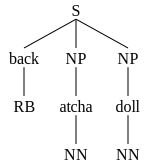

In [24]:
#check work -- note does not show in df.head()
print(df['message'][0])
df['message_np_parsed'][0]

In [25]:
#Select only the noun-phrases
df['message_np_pos'] = df.apply(lambda row: [i.leaves() for i in row['message_np_parsed'].subtrees(filter=lambda x: x.label() == 'NP')], axis = 1)

#Check work
df.head()

,id,message,length,country,date,message_clean,message_tokenized,message_pos,message_np_parsed,message_np_pos
0,1678,"Back atcha, doll!",17.0,united states,2011/1,back atcha doll,"[back, atcha, doll]","[(back, RB), (atcha, NN), (doll, NN)]","[(back, RB), [(atcha, NN)], [(doll, NN)]]","[[(atcha, NN)], [(doll, NN)]]"
1,1679,"Your message was blank! Same to you, LOL!",41.0,united states,2011/1,your message was blank same to you lol,"[your, message, was, blank, same, to, you, lol]","[(your, PRP$), (message, NN), (was, VBD), (bla...","[(your, PRP$), [(message, NN)], (was, VBD), (b...","[[(message, NN)]]"
2,1680,"Yoo silly! Luv ya much, lil sis.",32.0,united states,2011/1,yoo silly love ya much lil sis,"[yoo, silly, love, ya, much, lil, sis]","[(yoo, RB), (silly, RB), (love, VB), (ya, RB),...","[(yoo, RB), (silly, RB), (love, VB), (ya, RB),...","[[(sis, NN)]]"
3,1681,You betta be takin' pics!,25.0,united states,2011/1,you betta be takin pics,"[you, betta, be, takin, pics]","[(you, PRP), (betta, VBP), (be, VB), (takin, J...","[(you, PRP), (betta, VBP), (be, VB), (takin, J...",[]
4,1682,Jus bout.,9.0,united states,2011/1,jus bout,"[jus, bout]","[(jus, NN), (bout, NN)]","[[(jus, NN)], [(bout, NN)]]","[[(jus, NN)], [(bout, NN)]]"


In [26]:
#define function to drop the part-of-speech tag
def drop_pos(list):
    phrase_list = []
    phrase_strings = ""
    for i in range(len(list)):
        phrase_ranges = [j for j in range(len(list[i]))]
        phrase_list.append(["".join(list[i][k][0]) for k in phrase_ranges])
        phrase_strings_list = [' '.join(l) for l in phrase_list]
        phrase_strings = " ".join(phrase_strings_list)
    return phrase_strings
        
#drop the POS from the message_np
df['message_np'] = [drop_pos(x) for x in df['message_np_pos']]

#check work
df.head()

,id,message,length,country,date,message_clean,message_tokenized,message_pos,message_np_parsed,message_np_pos,message_np
0,1678,"Back atcha, doll!",17.0,united states,2011/1,back atcha doll,"[back, atcha, doll]","[(back, RB), (atcha, NN), (doll, NN)]","[(back, RB), [(atcha, NN)], [(doll, NN)]]","[[(atcha, NN)], [(doll, NN)]]",atcha doll
1,1679,"Your message was blank! Same to you, LOL!",41.0,united states,2011/1,your message was blank same to you lol,"[your, message, was, blank, same, to, you, lol]","[(your, PRP$), (message, NN), (was, VBD), (bla...","[(your, PRP$), [(message, NN)], (was, VBD), (b...","[[(message, NN)]]",message
2,1680,"Yoo silly! Luv ya much, lil sis.",32.0,united states,2011/1,yoo silly love ya much lil sis,"[yoo, silly, love, ya, much, lil, sis]","[(yoo, RB), (silly, RB), (love, VB), (ya, RB),...","[(yoo, RB), (silly, RB), (love, VB), (ya, RB),...","[[(sis, NN)]]",sis
3,1681,You betta be takin' pics!,25.0,united states,2011/1,you betta be takin pics,"[you, betta, be, takin, pics]","[(you, PRP), (betta, VBP), (be, VB), (takin, J...","[(you, PRP), (betta, VBP), (be, VB), (takin, J...",[],
4,1682,Jus bout.,9.0,united states,2011/1,jus bout,"[jus, bout]","[(jus, NN), (bout, NN)]","[[(jus, NN)], [(bout, NN)]]","[[(jus, NN)], [(bout, NN)]]",jus bout


In [27]:
#Drop missing
df['error'] = np.where(df['message_np']=="",1,0)
print(df['error'].value_counts())

df = df[df['error']==0].reset_index().drop(columns=['index','error'])

print(df.shape)
df.head()

0    5033
1     948
Name: error, dtype: int64
(5033, 11)


,id,message,length,country,date,message_clean,message_tokenized,message_pos,message_np_parsed,message_np_pos,message_np
0,1678,"Back atcha, doll!",17.0,united states,2011/1,back atcha doll,"[back, atcha, doll]","[(back, RB), (atcha, NN), (doll, NN)]","[(back, RB), [(atcha, NN)], [(doll, NN)]]","[[(atcha, NN)], [(doll, NN)]]",atcha doll
1,1679,"Your message was blank! Same to you, LOL!",41.0,united states,2011/1,your message was blank same to you lol,"[your, message, was, blank, same, to, you, lol]","[(your, PRP$), (message, NN), (was, VBD), (bla...","[(your, PRP$), [(message, NN)], (was, VBD), (b...","[[(message, NN)]]",message
2,1680,"Yoo silly! Luv ya much, lil sis.",32.0,united states,2011/1,yoo silly love ya much lil sis,"[yoo, silly, love, ya, much, lil, sis]","[(yoo, RB), (silly, RB), (love, VB), (ya, RB),...","[(yoo, RB), (silly, RB), (love, VB), (ya, RB),...","[[(sis, NN)]]",sis
3,1682,Jus bout.,9.0,united states,2011/1,jus bout,"[jus, bout]","[(jus, NN), (bout, NN)]","[[(jus, NN)], [(bout, NN)]]","[[(jus, NN)], [(bout, NN)]]",jus bout
4,1683,No it's MS. No p. And nope.,27.0,united states,2011/1,no it is ms no p and nope,"[no, it, is, ms, no, p, and, nope]","[(no, DT), (it, PRP), (is, VBZ), (ms, JJ), (no...","[(no, DT), (it, PRP), (is, VBZ), (ms, JJ), [(n...","[[(no, DT), (p, NN)], [(nope, NN)]]",no p nope


#### Lemmatize

In [30]:
lemmatizer = WordNetLemmatizer()

def get_part_of_speech(word):
    probable_part_of_speech = wordnet.synsets(word) #get synonyms
    pos_counts = Counter() #count the # of synonyms that fall into each part of speech
    pos_counts["n"] = len(  [ item for item in probable_part_of_speech if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in probable_part_of_speech if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in probable_part_of_speech if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in probable_part_of_speech if item.pos()=="r"]  )
    most_likely_part_of_speech = pos_counts.most_common(1)[0][0] #most likely pos based on most common count
    return most_likely_part_of_speech

#tokenize again
df['message_np_tokenized'] = [word_tokenize(x) for x in df['message_np']]

df['message_lemmas'] = df.apply(lambda row: [lemmatizer.lemmatize(token, get_part_of_speech(token)) for token in row["message_np_tokenized"]], axis=1)

#check work
df.head()

,id,message,length,country,date,message_clean,message_tokenized,message_pos,message_np_parsed,message_np_pos,message_np,message_np_tokenized,message_lemmas
0,1678,"Back atcha, doll!",17.0,united states,2011/1,back atcha doll,"[back, atcha, doll]","[(back, RB), (atcha, NN), (doll, NN)]","[(back, RB), [(atcha, NN)], [(doll, NN)]]","[[(atcha, NN)], [(doll, NN)]]",atcha doll,"[atcha, doll]","[atcha, doll]"
1,1679,"Your message was blank! Same to you, LOL!",41.0,united states,2011/1,your message was blank same to you lol,"[your, message, was, blank, same, to, you, lol]","[(your, PRP$), (message, NN), (was, VBD), (bla...","[(your, PRP$), [(message, NN)], (was, VBD), (b...","[[(message, NN)]]",message,[message],[message]
2,1680,"Yoo silly! Luv ya much, lil sis.",32.0,united states,2011/1,yoo silly love ya much lil sis,"[yoo, silly, love, ya, much, lil, sis]","[(yoo, RB), (silly, RB), (love, VB), (ya, RB),...","[(yoo, RB), (silly, RB), (love, VB), (ya, RB),...","[[(sis, NN)]]",sis,[sis],[si]
3,1682,Jus bout.,9.0,united states,2011/1,jus bout,"[jus, bout]","[(jus, NN), (bout, NN)]","[[(jus, NN)], [(bout, NN)]]","[[(jus, NN)], [(bout, NN)]]",jus bout,"[jus, bout]","[jus, bout]"
4,1683,No it's MS. No p. And nope.,27.0,united states,2011/1,no it is ms no p and nope,"[no, it, is, ms, no, p, and, nope]","[(no, DT), (it, PRP), (is, VBZ), (ms, JJ), (no...","[(no, DT), (it, PRP), (is, VBZ), (ms, JJ), [(n...","[[(no, DT), (p, NN)], [(nope, NN)]]",no p nope,"[no, p, nope]","[no, p, nope]"


#### Remove Stop words

In [31]:
# load stop words
stop_words = stopwords.words('english')

#Add greetings and laughter
add_stop_words = ['hey','hi','hello','lol','haha','caw']
for i in add_stop_words:
    stop_words.append(i)

In [32]:
df['message_n_stopwords'] = df.apply(lambda row: [x for x in row['message_lemmas'] if x not in stop_words], axis = 1)

df.head()

,id,message,length,country,date,message_clean,message_tokenized,message_pos,message_np_parsed,message_np_pos,message_np,message_np_tokenized,message_lemmas,message_n_stopwords
0,1678,"Back atcha, doll!",17.0,united states,2011/1,back atcha doll,"[back, atcha, doll]","[(back, RB), (atcha, NN), (doll, NN)]","[(back, RB), [(atcha, NN)], [(doll, NN)]]","[[(atcha, NN)], [(doll, NN)]]",atcha doll,"[atcha, doll]","[atcha, doll]","[atcha, doll]"
1,1679,"Your message was blank! Same to you, LOL!",41.0,united states,2011/1,your message was blank same to you lol,"[your, message, was, blank, same, to, you, lol]","[(your, PRP$), (message, NN), (was, VBD), (bla...","[(your, PRP$), [(message, NN)], (was, VBD), (b...","[[(message, NN)]]",message,[message],[message],[message]
2,1680,"Yoo silly! Luv ya much, lil sis.",32.0,united states,2011/1,yoo silly love ya much lil sis,"[yoo, silly, love, ya, much, lil, sis]","[(yoo, RB), (silly, RB), (love, VB), (ya, RB),...","[(yoo, RB), (silly, RB), (love, VB), (ya, RB),...","[[(sis, NN)]]",sis,[sis],[si],[si]
3,1682,Jus bout.,9.0,united states,2011/1,jus bout,"[jus, bout]","[(jus, NN), (bout, NN)]","[[(jus, NN)], [(bout, NN)]]","[[(jus, NN)], [(bout, NN)]]",jus bout,"[jus, bout]","[jus, bout]","[jus, bout]"
4,1683,No it's MS. No p. And nope.,27.0,united states,2011/1,no it is ms no p and nope,"[no, it, is, ms, no, p, and, nope]","[(no, DT), (it, PRP), (is, VBZ), (ms, JJ), (no...","[(no, DT), (it, PRP), (is, VBZ), (ms, JJ), [(n...","[[(no, DT), (p, NN)], [(nope, NN)]]",no p nope,"[no, p, nope]","[no, p, nope]","[p, nope]"


In [33]:
#Make message string again
df['message_final_str'] = [' '.join(map(str, x)) for x in df['message_n_stopwords']]

#check work
df.head()

,id,message,length,country,date,message_clean,message_tokenized,message_pos,message_np_parsed,message_np_pos,message_np,message_np_tokenized,message_lemmas,message_n_stopwords,message_final_str
0,1678,"Back atcha, doll!",17.0,united states,2011/1,back atcha doll,"[back, atcha, doll]","[(back, RB), (atcha, NN), (doll, NN)]","[(back, RB), [(atcha, NN)], [(doll, NN)]]","[[(atcha, NN)], [(doll, NN)]]",atcha doll,"[atcha, doll]","[atcha, doll]","[atcha, doll]",atcha doll
1,1679,"Your message was blank! Same to you, LOL!",41.0,united states,2011/1,your message was blank same to you lol,"[your, message, was, blank, same, to, you, lol]","[(your, PRP$), (message, NN), (was, VBD), (bla...","[(your, PRP$), [(message, NN)], (was, VBD), (b...","[[(message, NN)]]",message,[message],[message],[message],message
2,1680,"Yoo silly! Luv ya much, lil sis.",32.0,united states,2011/1,yoo silly love ya much lil sis,"[yoo, silly, love, ya, much, lil, sis]","[(yoo, RB), (silly, RB), (love, VB), (ya, RB),...","[(yoo, RB), (silly, RB), (love, VB), (ya, RB),...","[[(sis, NN)]]",sis,[sis],[si],[si],si
3,1682,Jus bout.,9.0,united states,2011/1,jus bout,"[jus, bout]","[(jus, NN), (bout, NN)]","[[(jus, NN)], [(bout, NN)]]","[[(jus, NN)], [(bout, NN)]]",jus bout,"[jus, bout]","[jus, bout]","[jus, bout]",jus bout
4,1683,No it's MS. No p. And nope.,27.0,united states,2011/1,no it is ms no p and nope,"[no, it, is, ms, no, p, and, nope]","[(no, DT), (it, PRP), (is, VBZ), (ms, JJ), (no...","[(no, DT), (it, PRP), (is, VBZ), (ms, JJ), [(n...","[[(no, DT), (p, NN)], [(nope, NN)]]",no p nope,"[no, p, nope]","[no, p, nope]","[p, nope]",p nope


In [34]:
#Drop missing
df['error'] = np.where(df['message_final_str'].isnull(),1,0)
print(df['error'].value_counts())

df = df[df['error']==0].reset_index().drop(columns=['index','error'])

print(df.shape)
df.head()

0    5033
Name: error, dtype: int64
(5033, 15)


,id,message,length,country,date,message_clean,message_tokenized,message_pos,message_np_parsed,message_np_pos,message_np,message_np_tokenized,message_lemmas,message_n_stopwords,message_final_str
0,1678,"Back atcha, doll!",17.0,united states,2011/1,back atcha doll,"[back, atcha, doll]","[(back, RB), (atcha, NN), (doll, NN)]","[(back, RB), [(atcha, NN)], [(doll, NN)]]","[[(atcha, NN)], [(doll, NN)]]",atcha doll,"[atcha, doll]","[atcha, doll]","[atcha, doll]",atcha doll
1,1679,"Your message was blank! Same to you, LOL!",41.0,united states,2011/1,your message was blank same to you lol,"[your, message, was, blank, same, to, you, lol]","[(your, PRP$), (message, NN), (was, VBD), (bla...","[(your, PRP$), [(message, NN)], (was, VBD), (b...","[[(message, NN)]]",message,[message],[message],[message],message
2,1680,"Yoo silly! Luv ya much, lil sis.",32.0,united states,2011/1,yoo silly love ya much lil sis,"[yoo, silly, love, ya, much, lil, sis]","[(yoo, RB), (silly, RB), (love, VB), (ya, RB),...","[(yoo, RB), (silly, RB), (love, VB), (ya, RB),...","[[(sis, NN)]]",sis,[sis],[si],[si],si
3,1682,Jus bout.,9.0,united states,2011/1,jus bout,"[jus, bout]","[(jus, NN), (bout, NN)]","[[(jus, NN)], [(bout, NN)]]","[[(jus, NN)], [(bout, NN)]]",jus bout,"[jus, bout]","[jus, bout]","[jus, bout]",jus bout
4,1683,No it's MS. No p. And nope.,27.0,united states,2011/1,no it is ms no p and nope,"[no, it, is, ms, no, p, and, nope]","[(no, DT), (it, PRP), (is, VBZ), (ms, JJ), (no...","[(no, DT), (it, PRP), (is, VBZ), (ms, JJ), [(n...","[[(no, DT), (p, NN)], [(nope, NN)]]",no p nope,"[no, p, nope]","[no, p, nope]","[p, nope]",p nope


## Tf-idf<a class="anchor" id="4"></a>

In [45]:
#Calculate tfidf
vectorizer = TfidfVectorizer(norm=None, ngram_range=(2, 3)) 
tfidf_vectorizer = vectorizer.fit_transform(df['message_final_str'])

#Get the words
feature_names = vectorizer.get_feature_names_out()

#Create a dataframe with each noun-phrase as columns and their tf-idf value in rows
df_tf_idf = pd.DataFrame(tfidf_vectorizer.toarray(),columns=list(feature_names))

df_tf_idf

,2nd floor,2nd floor mbr,aaaaaaaaaaaaaaaaa pronounce,aaaaaaaaaaaaaaaaa pronounce wellsfargobacon,aaaahhhh psssyyyych,aaaarrreee yooooouuuu,aaahhh yeeeahhh,aahhhh shooop,aaooooright work,abi mj,...,yup rw,yup rw reaction,yup sup,zac chance,ze practice,ze practice room,zero check,zit problem,zit seng,zit seng min
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## LDA<a class="anchor" id="5"></a>

In [46]:
# creating the tf-idf LDA model,  n topics, online learning method, set random state to replicate
num_topics = 4

lda_tfidf_creator = LatentDirichletAllocation(learning_method='online', n_components=num_topics, random_state=22)
lda_tfidf = lda_tfidf_creator.fit_transform(df_tf_idf)

#print perplexity score (how well fits sample)
print(round(lda_tfidf_creator.bound_,4))

5300.9291


In [50]:
#Create a dictionary with each topic
topic_dict = {}

#Get the words from the tfidf vector
words = vectorizer.get_feature_names_out()

#Iterate through the number of topics created
for i in range(num_topics):
    #Get the pseudocount for number of times each word was assigned to the topic
    pcount = list(lda_tfidf_creator.components_[i])
    #Create a df with words and their counts for the current topic
    topic_df = pd.DataFrame({'feature_words': words, 'topic_counts': pcount})
    #Sort the df by the topic counts in descending order, and reset index
    topic_df = topic_df.sort_values(by='topic_counts', ascending = False).reset_index()
    #Filter to the top 8 words associated with that topic
    topic_df = topic_df.iloc[0:5]
    #Store the topic count for the most frequently assigned word in max_topic
    max_topic = topic_df['topic_counts'][0]
    #For each following word, calculate a percent change from the most frequently assigned word
    topic_df['perc_change'] = [abs(round(((max_topic - x)/max_topic)*100,2)) for x in topic_df['topic_counts']]
    #Drop any words that are assigned 30% less frequently than the most frequently assigned word
    ### words that are very different from the most frequently assigned word, may not be representative of the topic
    topic_df = topic_df[topic_df['perc_change']<10]
    #create a list with the topic words
    topic = " ".join(topic_df['feature_words'].to_list())
    topic_dict.update({i : "topic_" + str(i+1) + ": " + topic})

for key, value in topic_dict.items():
    print(value)

topic_1: great day good morning
topic_2: last night
topic_3: new year
topic_4: sorry love choa chu good luck


In [55]:
#Merge the lda_topics back into the df
df['lda_topics'] = lda_tfidf.argmax(axis=1)

#Relabel the topics based on the dictionary
df['lda_topics'] = df['lda_topics'].map(topic_dict)

#See distribution
round(df['lda_topics'].value_counts(normalize=True) * 100,2)

topic_1: great day good morning           56.21
topic_2: last night                       15.10
topic_4: sorry love choa chu good luck    14.84
topic_3: new year                         13.85
Name: lda_topics, dtype: float64

* More than half of the text messages were general greetings or related to the day
* 15% were related to some previous incident ('last night')
* 15% included terms of endearment and well wishes
* About 14% were related to the New Year -- (16% of messages were sent in January)

## Sentiment Analysis<a class="anchor" id="6"></a>

In [69]:
from textblob import TextBlob
df['sentiment'] = df['message'].astype(str).apply(lambda x:TextBlob(x).sentiment.polarity)
df = df.sort_values(by='sentiment', ascending=False)

In [70]:
#Average sentiment score
round(np.mean(df['sentiment']),2)

0.12

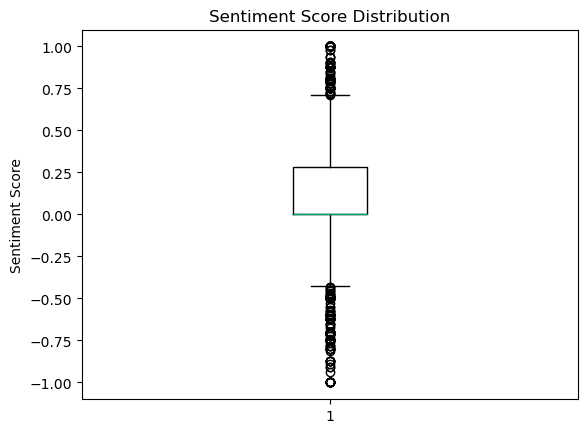

In [71]:
import matplotlib.pyplot as plt 
#View distribution box plot
plt.boxplot(df['sentiment'])
plt.title('Sentiment Score Distribution')
plt.ylabel('Sentiment Score')
plt.show()

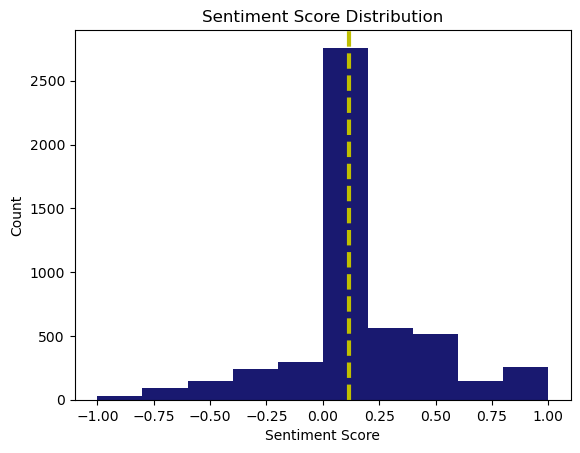

In [72]:
#View distribution histogram
plt.hist(df['sentiment'], color='midnightblue')
plt.axvline(df['sentiment'].mean(), color='y', linestyle='dashed', linewidth=3)

plt.style.use('seaborn-colorblind')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

The sentiment of the messages was mostly neutral with mean of 0.12 and a slightly positive skew.

## Conclusion<a class="anchor" id="7"></a>

* Topic Modeling:
    * Due to the short length of the documents (text messages), the topic models had a limited sample of words to build from and were not matched exactly to each message. They did however identify some common themes across the messages.
    * The most common theme included general greetings and thoughts about the day, while a smaller percentage were related to the past, terms of endearment, and the new year. 

* Sentiment Analysis:
    * Considering the most common theme was a general greeting, it is not surprising that the sentiment of messages was generally neutral.
    * The slightly positive skew also makes sense with the messages with terms of endearment and wishing a happy new year.